In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
import re

# Web page is dynamic, so we have to use Selenium to get the tables from the HTML source. 
driver = webdriver.Chrome('D:\ChromeDriver\chromedriver.exe')

# get the hockey table
driver.get("https://en.wikipedia.org/wiki/Michigan%E2%80%93Michigan_State_men%27s_ice_hockey_rivalry")
html = driver.page_source

tables = pd.read_html(html)
hockey = tables[6]

# get the basketball table
driver.get("https://en.wikipedia.org/wiki/Michigan%E2%80%93Michigan_State_men%27s_basketball_rivalry")
html = driver.page_source

tables = pd.read_html(html)
bball = tables[4]

# get the football table
driver.get("https://en.wikipedia.org/wiki/Michigan%E2%80%93Michigan_State_football_rivalry")
html = driver.page_source

tables = pd.read_html(html)
fball = tables[4]

# get the football table
driver.get("https://en.wikipedia.org/wiki/Michigan%E2%80%93Michigan_State_men%27s_soccer_rivalry")
html = driver.page_source

tables = pd.read_html(html)
soccer = tables[2]

driver.close()

# basketball data cleanup
cols = bball.loc[1]
bball.rename(columns=cols, inplace=True) # set the column labels
bball.drop(index=[0,1,191,192, 97], inplace=True) # remove rows containing non relevant data i.e. header and footer
bball.dropna(axis=1, inplace=True, how='any') # remove bad cols with 'Na' only values
bball['Winner'].replace(to_replace = [r'(No.\s[\d]*\s)', '†', '(^[A-Z][a-z]*\s[\d]*\,\s)'], value='', regex=True, inplace=True) # clean up Winner column 
bball['Date'].replace(to_replace = r'(^[A-Z][a-z]*\s[\d]*\,\s)', value='', regex=True, inplace=True) # Strip month-day from Date column
bball['Date'] = pd.to_numeric(bball['Date'], downcast='integer') # convert Years from strings to ints
bball.set_index(bball['Date'], inplace=True)
bball.drop(columns='Date', inplace=True)


# hockey data cleanup
cols = hockey.loc[1]
hockey.rename(columns=cols, inplace=True) # set the column labels
hockey.drop(index=[0,1, hockey.index[-1]], columns = ['Location', 'Score'], inplace=True) # remove header and footer
hockey.dropna(axis=1, inplace=True, how='any') # remove bad cols with 'Na' only values
hockey.set_index(hockey['Date'], inplace=True)
hockey.drop(columns='Date', inplace=True)
hockey.drop(index=['Date'], inplace=True) # drop those rows whose index contains table names from the HTML table formatting
hockey['Winner'].replace(to_replace = [r'(No.\s[\d]*\s)', '(^[A-Z][a-z]*\s[\d]*\,\s)'], value='', regex=True, inplace=True) # clean up Winner column 
hockey.index = pd.to_numeric(hockey.index, downcast='integer') # convert Years from strings to ints

# football table cleanup
cols = fball.loc[1]
fball.rename(columns=cols, inplace=True) # set the column labels
fball.drop(index=[0,1, fball.index[-1]],  inplace=True) # remove header and footer
fball.dropna(axis=1, inplace=True, how='all') # remove bad cols with 'Na' only values
fball.dropna(axis=0, inplace=True, how='any') # remove bad rows with 'Na' only values
fball.set_index(fball['Date'], inplace=True) # set date/year as index
fball.drop(columns=['Date', 'Location', 'Score'], inplace=True) # remove redundant date col and other unecessary cols
fball.drop(index=['Date'], inplace=True) # drop those rows whose index contains table names from the HTML table formatting
fball['Winner'].replace(to_replace = [r'(No.\s[\d]*\s)', '(^[A-Z][a-z]*\s[\d]*\,\s)'], value='', regex=True, inplace=True) # clean up Winner column 
fball.index = pd.to_numeric(fball.index, downcast='integer') # convert Years from strings to ints

# soccer table cleanup
cols = soccer.loc[1]
soccer.rename(columns=cols, inplace=True) # set the column labels
soccer.drop(index=[0,1, soccer.index[-1]],  inplace=True) # remove header and footer
soccer.dropna(axis=1, inplace=True, how='all') # remove bad cols with 'Na' only values
soccer.dropna(axis=0, inplace=True, how='any') # remove bad rows with 'Na' only values
soccer['Date'].replace(to_replace = r'(^[A-Z][a-z]*\s[\d]*\,\s)', value='', regex=True, inplace=True) # Strip month-day from Date column
soccer.set_index(soccer['Date'], inplace=True) # set date/year as index
soccer.drop(columns=['Date', 'Location', 'Score'], inplace=True) # remove redundant date col and other unecessary cols
soccer.drop(index=['Date'], inplace=True) # drop those rows whose index contains table names from the HTML table formatting
soccer['Winner'].replace(to_replace = [r'(No.\s[\d]*\s)', '(^[A-Z][a-z]*\s[\d]*\,\s)'], value='', regex=True, inplace=True) # clean up Winner column 
soccer.index = pd.to_numeric(soccer.index, downcast='integer') # convert Years from strings to ints




In [97]:
def calc_win_per(frame):
    df = pd.DataFrame(index=frame.index)
    win_count = 0
    wins = []
    total_games = 1
    
    for team in frame['Winner']:
        if team == 'Michigan':
            win_count += 1
        wins.append(win_count/total_games)
        total_games += 1
    
    df['Michigan Win %'] = wins
    df['Michigan Win %'] = df['Michigan Win %'].rolling(10, min_periods=1).mean()
    return df

bball = calc_win_per(bball)
soccer = calc_win_per(soccer)
fball = calc_win_per(fball)
hockey = calc_win_per(hockey)


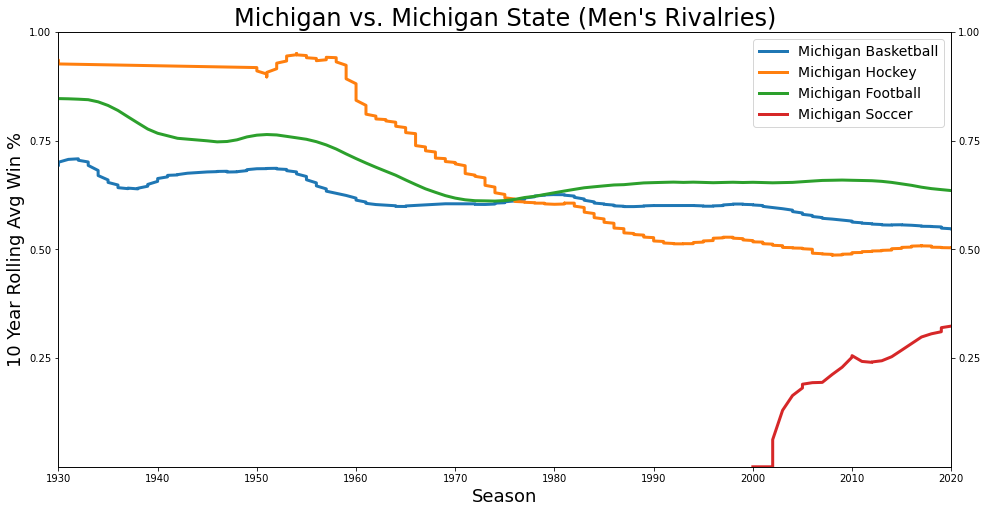

In [104]:
fig = plt.figure(figsize=(16,8))
ax = plt.gca()
ax2 = ax.twinx() # for duplicating y-axis on RHS
plt.plot(bball.index, list(bball['Michigan Win %']), label='Michigan Basketball', linewidth=3)
plt.plot(hockey.index, list(hockey['Michigan Win %']), label='Michigan Hockey', linewidth=3)
plt.plot(fball.index, list(fball['Michigan Win %']), label='Michigan Football', linewidth=3)
plt.plot(soccer.index, list(soccer['Michigan Win %']), label='Michigan Soccer', linewidth=3)
ax.set_ylabel('10 Year Rolling Avg Win %', fontsize=18)
ax.set_xlabel('Season', fontsize=18)
plt.title("Michigan vs. Michigan State (Men's Rivalries)", fontsize=24)
ax.set_yticks([0.25, 0.5, 0.75, 1])
ax2.set_yticks([0.25, 0.5, 0.75, 1])
ax.set_xlim(1930, 2020)
ax.set_ylim(0, 1)
ax2.set_ylim(0, 1)
plt.legend(fontsize=14)
plt.savefig('project.svg', format='svg')
plt.show()

In [91]:
# hockey_m_win = 0
# hockey_m = []
# total_games = 1

# for team in hockey['Winner']:
#     if team == 'Michigan':
#         hockey_m_win += 1
#     hockey_m.append(hockey_m_win/total_games)
#     total_games += 1

# hockey['Michigan Win %'] = hockey_m
    
# t = hockey.groupby(hockey.index)['Michigan Win %'].mean()
# hockey = pd.DataFrame(index = t.index, data={'Michigan Win %': t.values})
# hockey['Michigan Win %'] = hockey['Michigan Win %'].rolling(10, min_periods=1).mean()

# fball_m_win = 0
# fball_m = []
# total_games = 1

# for team in fball['Winner']:
#     if team == 'Michigan':
#         fball_m_win += 1
#     fball_m.append(fball_m_win/total_games)
#     total_games += 1

# fball['Michigan Win %'] = fball_m
    
# t = fball.groupby(fball.index)['Michigan Win %'].mean()
# fball = pd.DataFrame(index = t.index, data={'Michigan Win %': t.values})
# fball['Michigan Win %'] = fball['Michigan Win %'].rolling(10, min_periods=1).mean()

# soccer_m_win = 0
# soccer_m = []
# total_games = 1

# for team in soccer['Winner']:
#     if team == 'Michigan':
#         soccer_m_win += 1
#     soccer_m.append(soccer_m_win/total_games)
#     total_games += 1

# soccer['Michigan Win %'] = soccer_m
    
# t = soccer.groupby(soccer.index)['Michigan Win %'].mean()
# soccer = pd.DataFrame(index = t.index, data={'Michigan Win %': t.values})
# soccer['Michigan Win %'] = soccer['Michigan Win %'].rolling(10, min_periods=1).mean()
